In [3]:
import os, sys, torch, tqdm
sys.path.append('../')
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from utils.spectrum import read_spectrum, norm_spectrum, wave_unit_converters
from utils.visualize import clustering_summary, clustering_details, plot_map
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gs

import numpy as np
from docx import Document
from docx.shared import Inches
from io import BytesIO

# PCA + K-means

In [4]:
root = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/'
fns = np.array(sorted([f.split('.')[0] for f in os.listdir(root) if f.startswith('9') and f.endswith('txt')])).astype(int)
fns

array([900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912,
       913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925,
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965])

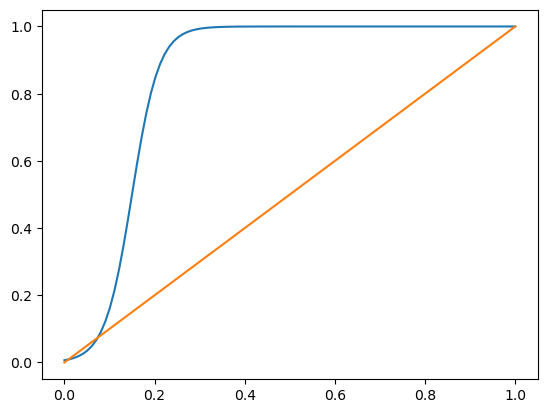

In [3]:
z = np.linspace(0, 1, 100)
w = 1 / (1 + np.exp((-z + 0.15)/0.03))
plt.plot(z, w)
plt.plot([0,1],[0,1])


In [28]:
# main input file
def masking_spectrum(ny, verbose=0, return_mask=False):
    nx, n1, n2 = ny.shape
    std = ny.reshape(nx, -1).std(1)
    _, _, nstd = norm_spectrum(std, std, n=500, num_bit=0, min_count=2)
    mask = nstd > 0.15
    se_pair = np.where(np.diff(np.concatenate(([False], mask, [False]))))[0].reshape(-1, 2)
    if verbose == 2:
        print(se_pair)

    for s, e in se_pair:
        if e - s < nx * 0.01:
            mask[s:e] = False
    se_pair = np.where(np.diff(np.concatenate([[False], mask, [False]])))[0].reshape(-1,2)
    if verbose == 2:
        print(se_pair)

    e0 = se_pair[0][1]
    for s, e in se_pair[1:]:
        if s - e0 < nx * 0.1:
            mask[e0:s] = True
        e0 = e
    se_pair = np.where(np.diff(np.concatenate([[False], mask, [False]])))[0].reshape(-1,2)
    if verbose == 2:
        print(se_pair)

    if se_pair[-1,-1] >= nx:
        se_pair[-1,-1] = nx-1
    if se_pair[0,0] < 0:
        se_pair[0,0] = 0
    if verbose:
        print(se_pair)

    if return_mask:
        m = np.zeros(nx, dtype=bool)
        for s, e in se_pair:
            m[s:e] = True
        return m
    else:
        return se_pair

def plot_info_and_maps(x, y, verbose=0):
    grid = (6, 6)
    n_total = np.prod(grid)
    nx, n1, n2 = y.shape

    vmin, vmax, ny = norm_spectrum(y, num_bit=0, min_count=5)
    std = ny.reshape(nx, -1).std(1)

    if verbose:
        print(nx, n1, n2, f'{vmin:12.3f} {vmax:12.3f}')

    dx = np.mean(x[2:] - x[:-2])

    se_pair = masking_spectrum(y, verbose=verbose, return_mask=False)

    lengths = np.diff(se_pair.reshape(-1))[::2]
    ns = np.round(n_total * lengths / np.sum(lengths)).astype(int)
    if verbose == 2:
        print(ns)

    num_2 = 10
    num_3 = 7
    if len(ns) == 2 and ns.min() < num_2:
        ns[ns > num_2] = n_total - num_2
        ns[ns < num_2] = num_2
    if len(ns) > 2 and ns.min() < num_3:
        k = num_3 * np.sum(ns < num_3) - np.sum(ns[ns < num_3])
        ns[ns < num_3] = num_3
        ns[ns.argmax()] -= k        
    if verbose:
        print(ns)

    locs = []
    for (s, e), n in zip(se_pair, ns):
        locs.append(np.linspace(x[s], x[e], n))
        if verbose:
            print('{:10.1f} {:10.1f} {:4d}'.format(x[s], x[e], n))

    locs = np.hstack(locs)

    # std and sample
    f, axs = plt.subplots(1,2,figsize=(13,3))
    x_ev = wave_unit_converters['nm']['eV'](x)
    axs[0].plot(x_ev, std, label=f'{nx}x{n1}x{n2}\ndx: {dx:16.3f}\nmin: {vmin:12.2f}\nmax:{vmax:10.2f}')
    idxs = np.random.randint(0, n1*n2, 8)
    rys = y.reshape(nx, -1).T[idxs]
    for i, ry in zip(idxs, rys):
        axs[1].plot(x_ev, ry, label=str(i))
    for ax in axs: 
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax.legend(loc='upper right')
        for s, e in np.hstack([x_ev[0], x_ev[se_pair.reshape(-1)], x_ev[-1]]).reshape(-1,2):
            ax.axvspan(s, e, color='grey', alpha=0.5)
            
    mem1 = BytesIO()
    f.savefig(mem1, bbox_inches='tight')

    # map
    stdmap = y.reshape(nx, -1).std(0).reshape(n1,n2)
    k = np.argmin([
        stdmap[:int(n1*0.3), :int(n1*0.4)].mean(),
        stdmap[:int(n1*0.3), int(n1*0.6):].mean(),
        stdmap[int(n1*0.7):, :int(n1*0.4)].mean(),
        stdmap[int(n1*0.7):, int(n1*0.6):].mean(),
    ])

    loc_txt = [
        [n1*0.05,n2*0.2],
        [n1*0.6,n2*0.2],
        [n1*0.05,n2*0.92],
        [n1*0.6,n2*0.92],
    ][k]

    f, axs = plt.subplots(*grid,figsize=(15,15*grid[0]/grid[1]))
    for l, ax in zip(locs, axs.reshape(-1)):
#        plot_map(ax, x, y.transpose(0,2,1), l, tol=dx, vmin=vmin, vmax=vmax*0.5, grid=True)
        plot_map(ax, x, y, l, tol=dx, vmin=vmin, vmax=vmax * 0.8, grid=True)
        e = wave_unit_converters['nm']['eV'](l)
        txt = ax.text(*loc_txt, f'{l:.1f} nm\n{e:.3f} eV', color=[1,1,1], fontsize=11)
        txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
#        ax.invert_xaxis()
#        ax.invert_yaxis()
    f.subplots_adjust(hspace=0.02, wspace=0.02)
    mem2 = BytesIO()
    f.savefig(mem2, bbox_inches='tight')
    return mem1, mem2

def plot_cluster(x, y, norm_std=0, method='kmeans'):
    num_clusters = 5
    num_exmaples = 7
    random_state = 100

    nx, n1, n2 = y.shape
    _, _, ny = norm_spectrum(y, num_bit=0)

    for _ in range(norm_std):
        _, _, nstd = norm_spectrum(ny.reshape(nx, -1).std(1), num_bit=0, n=500, min_count=2)
        c = 1 / (1 + np.exp((-nstd + 0.15)/0.03))
        _, _, ny = norm_spectrum(c.reshape(-1,1,1) * ny, num_bit=0, min_count=5)
    
    mask = masking_spectrum(ny, return_mask=True)
    masked_spectrum = ny.reshape(nx, -1)[mask].T

    pca = PCA(n_components=15)
    pca_vector = pca.fit_transform(masked_spectrum)

    # clustering sample area
    if method.lower().startswith('g'):
        model = BayesianGaussianMixture(n_components=num_clusters, random_state=random_state, covariance_type='spherical')
    elif method.lower().startswith('k'):
        model = KMeans(n_clusters=num_clusters, random_state=random_state, n_init='auto')
    else:
        raise ValueError('Unknown method')
    tsne = TSNE(perplexity=30, init='pca', random_state=random_state, learning_rate='auto')
    tsne_vector = tsne.fit_transform(masked_spectrum)
    l1 = model.fit_predict(pca_vector)
#    l1 = model.fit_predict(masked_spectrum)
#    l1 = model.fit_predict(tsne_vector)

    labels = np.ones(n1*n2, dtype=int) * -1
    if len(np.unique(l1)) != num_clusters:
        print('Number of clusters changed: {} -> {}'.format(num_clusters, len(np.unique(l1))))
        for i, j in enumerate(np.unique(l1)):
            l1[l1 == j] = i
        num_clusters = len(np.unique(l1))
    l2 = l1.copy()
    for i, j in enumerate(sorted(np.unique(l1), key=lambda x: masked_spectrum[l1 == x].var(1).mean())):
        l2[l1 == j] = i

    labels = l2.reshape(n1,n2)
    
    # summary figure
    f1 = plt.figure(figsize=(15,4))
    bounds = np.linspace(0,num_clusters,num_clusters+1)
    cmap = mpl.cm.viridis
    cmap.set_under([0.7, 0.7, 0.7])

    outer_grid = gs.GridSpec(1, 3, f1, width_ratios=[1.3,1,1], wspace=0.05)
    inner_grid = gs.GridSpecFromSubplotSpec(3,4,subplot_spec=outer_grid[0], wspace=0.05, hspace=0.3)
    for ig, p in zip(inner_grid, pca_vector.T):
        ax = plt.subplot(ig)
        z = np.abs(p).max()
        im = ax.imshow(p.reshape(n1,n2), cmap='bwr', vmin=-z, vmax=z)
        ax.axis('off')
        cb = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, fraction=0.04)
        cb.ax.tick_params(labelsize=8)
        f1.add_subplot(ax)

    ax0 = f1.add_subplot(outer_grid[0])
    ax0.set_title('PCA')
    ax0.axis('off')

    ax1 = f1.add_subplot(outer_grid[1])
    ax1.set_title('t-SNE')
    im = ax1.scatter(*tsne_vector.T, c=labels.reshape(-1), vmin=0, vmax=num_clusters-1, cmap=cmap)
    cb = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.05, 
                      ticks=bounds, boundaries=bounds-0.5, extend='min')
    cb.set_label('Cluster')

    ax2 = f1.add_subplot(outer_grid[2])
    ax2.set_title('Sample')
    ax2.imshow(labels, vmin=0, vmax=num_clusters-1, cmap=cmap)

    for ax in [ax1, ax2]:
        ax.set_xticks([])
        ax.set_yticks([])
        
    # detail figure
    f2 = clustering_details(x, y, tsne_vector, labels, num_exmaples, figsize=(15, 3), 
                            fontsize=12, gridspec_kw={'width_ratios':[2,1,1]}, xunit='eV')
    mem1 = BytesIO()
    mem2 = BytesIO()
    f1.savefig(mem1, bbox_inches='tight')
    f2.savefig(mem2, bbox_inches='tight')
    return mem1, mem2


In [23]:
plt.ioff()


In [29]:
root = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/'
ns = np.array(sorted([f.split('.')[0] for f in os.listdir(root) if f.startswith('9') and f.endswith('txt')])).astype(int)
doc = Document()
section = doc.sections[0]
section.left_margin = Inches(0.5)
section.right_margin = Inches(0.5)
section.top_margin = Inches(0.5)
section.bottom_margin = Inches(0.5)

#for n in ns:
pbar = tqdm.tqdm(total = len(ns))
for n in ns:
    x, y = read_spectrum(n, root)
    if y.shape[1] < 15: continue
    if y.shape[0] < 200: continue
    m1, m2 = plot_info_and_maps(x, y, verbose=0)
    p = doc.add_paragraph(f'#{n}')
    p.paragraph_format.space_after = 0
    doc.add_picture(m1, Inches(5.5))
    doc.add_picture(m2, Inches(7))
    doc.add_page_break()
    doc.add_paragraph('Gaussian Mixture')
    m3, m4= plot_cluster(x, y, norm_std=3, method='g')
    doc.add_picture(m3, Inches(7))
    doc.add_picture(m4, Inches(6.5))
    doc.add_page_break()
    doc.add_paragraph('K-means clustering')
    m3, m4= plot_cluster(x, y, norm_std=3, method='k')
    doc.add_picture(m3, Inches(7))
    doc.add_picture(m4, Inches(6.5))
    doc.add_page_break()
    plt.close('all')
    pbar.update(1)
doc.save('data.docx')

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Number of clusters changed: 5 -> 4
Number of clusters changed: 5 -> 4
Number of clusters changed: 5 -> 3
Number of clusters changed: 5 -> 4
Number of clusters changed: 5 -> 4


In [467]:
input_file = f'/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/905.txt'

x, y = read_spectrum(input_file)
nx, n1, n2 = y.shape

#m1, m2 = plot_info_and_maps(x, y, verbose=2)
vmin, vmax, ny = norm_spectrum(y, num_bit=0, min_count=5)
std = ny.reshape(nx, -1).std(1)
smin, smax = std.min(), std.max()
np.histogram(std.reshape(-1), 500)
#_ = plot_cluster(x, y, norm_std=3, method='g')
#_ = plot_cluster(x, y, norm_std=3, method='k')

(array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [477]:
plt.ion()

In [19]:
root = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/'

x, y = read_spectrum(902, root)
#plot_cluster(x, y, 3)
#plot_cluster(x, y, 3, method='g')

1283.8768499999999 2567.7536999999998


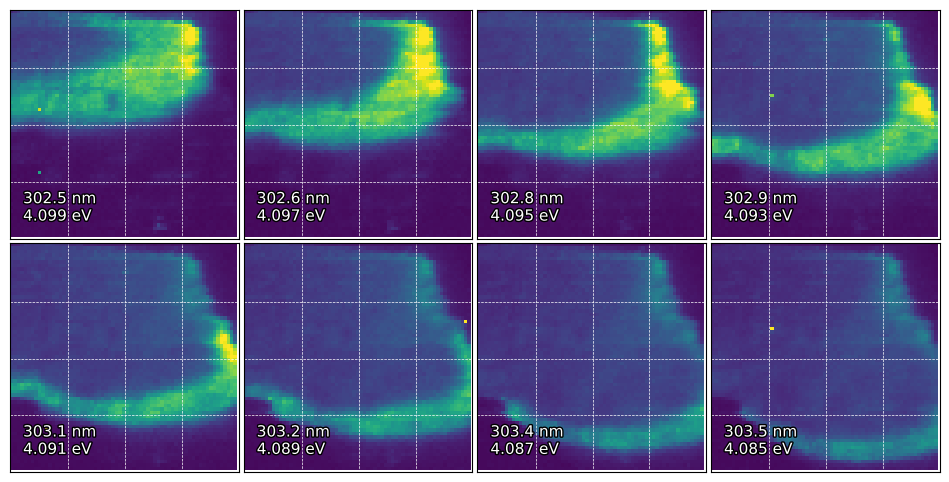

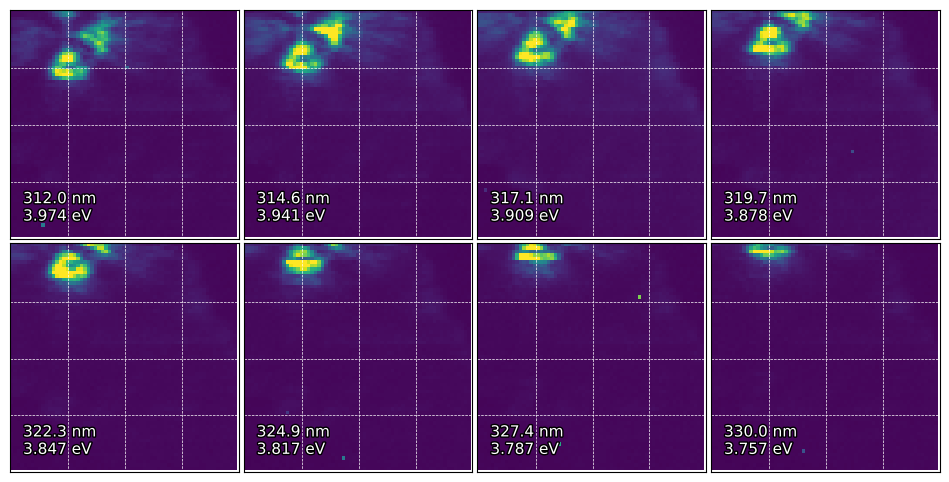

In [21]:
vmin, vmax, ny = norm_spectrum(y, num_bit=0, min_count=5)
grid = 2,4
nx, n1, n2 = y.shape
dx = np.mean(x[2:] - x[:-2])
stdmap = y.reshape(nx, -1).std(0).reshape(n1,n2)
k = np.argmin([
    stdmap[:int(n1*0.3), :int(n1*0.4)].mean(),
    stdmap[:int(n1*0.3), int(n1*0.6):].mean(),
    stdmap[int(n1*0.7):, :int(n1*0.4)].mean(),
    stdmap[int(n1*0.7):, int(n1*0.6):].mean(),
])

loc_txt = [
    [n1*0.05,n2*0.2],
    [n1*0.6,n2*0.2],
    [n1*0.05,n2*0.92],
    [n1*0.6,n2*0.92],
][k]

locs = np.linspace(302.5,303.5, 8)
f, axs = plt.subplots(*grid,figsize=(12,12*grid[0]/grid[1]))
for l, ax in zip(locs, axs.reshape(-1)):
#        plot_map(ax, x, y.transpose(0,2,1), l, tol=dx, vmin=vmin, vmax=vmax*0.5, grid=True)
    plot_map(ax, x, y, l, tol=dx, vmin=vmin, vmax=vmax * 0.3, grid=True)
    e = wave_unit_converters['nm']['eV'](l)
    txt = ax.text(*loc_txt, f'{l:.1f} nm\n{e:.3f} eV', color=[1,1,1], fontsize=11)
    txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
#        ax.invert_xaxis()
#        ax.invert_yaxis()
f.subplots_adjust(hspace=0.02, wspace=0.02)

locs = np.linspace(312, 330, 8)
f, axs = plt.subplots(*grid,figsize=(12,12*grid[0]/grid[1]))
for l, ax in zip(locs, axs.reshape(-1)):
#        plot_map(ax, x, y.transpose(0,2,1), l, tol=dx, vmin=vmin, vmax=vmax*0.5, grid=True)
    plot_map(ax, x, y, l, tol=dx, vmin=vmin, vmax=vmax * 0.6, grid=True)
    e = wave_unit_converters['nm']['eV'](l)
    txt = ax.text(*loc_txt, f'{l:.1f} nm\n{e:.3f} eV', color=[1,1,1], fontsize=11)
    txt.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
#        ax.invert_xaxis()
#        ax.invert_yaxis()
f.subplots_adjust(hspace=0.02, wspace=0.02)

print(vmax * 0.3, vmax * 0.6)

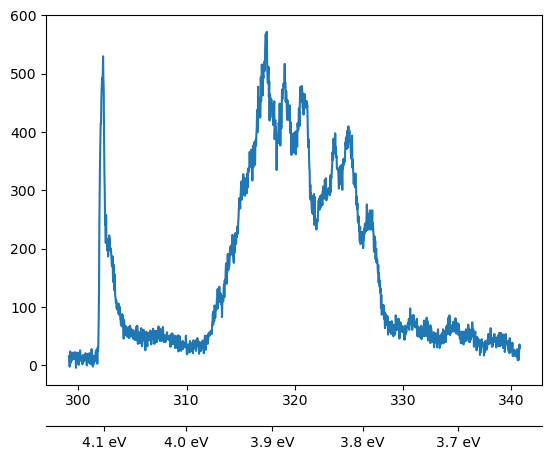

In [498]:
f, ax = plt.subplots(1,1)
ax.plot(x, y[:, 1,2])

ax_ev = ax.secondary_xaxis('bottom', 
                            functions=(wave_unit_converters['nm']['eV'], 
                                        wave_unit_converters['eV']['nm']))
ax_ev.xaxis.set_major_formatter(lambda x, y: '{:.1f} eV'.format(x))
ax_ev.spines[:].set_position(('outward',30))



g


/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


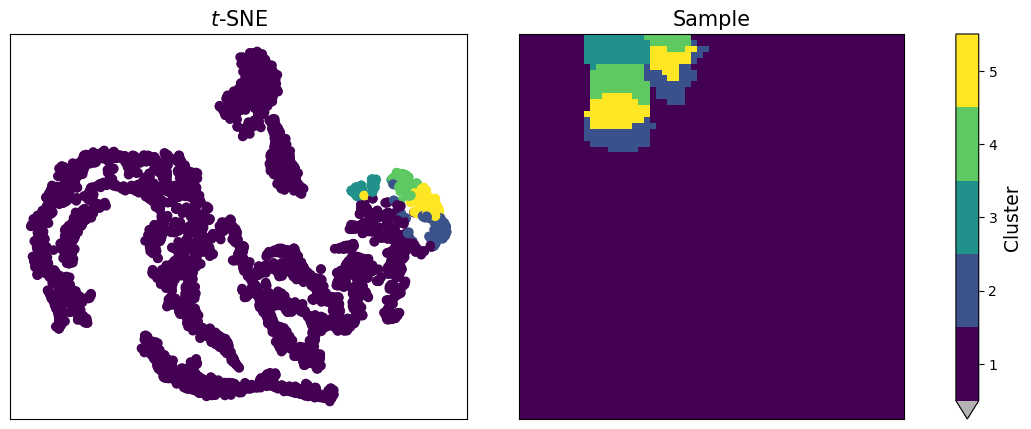

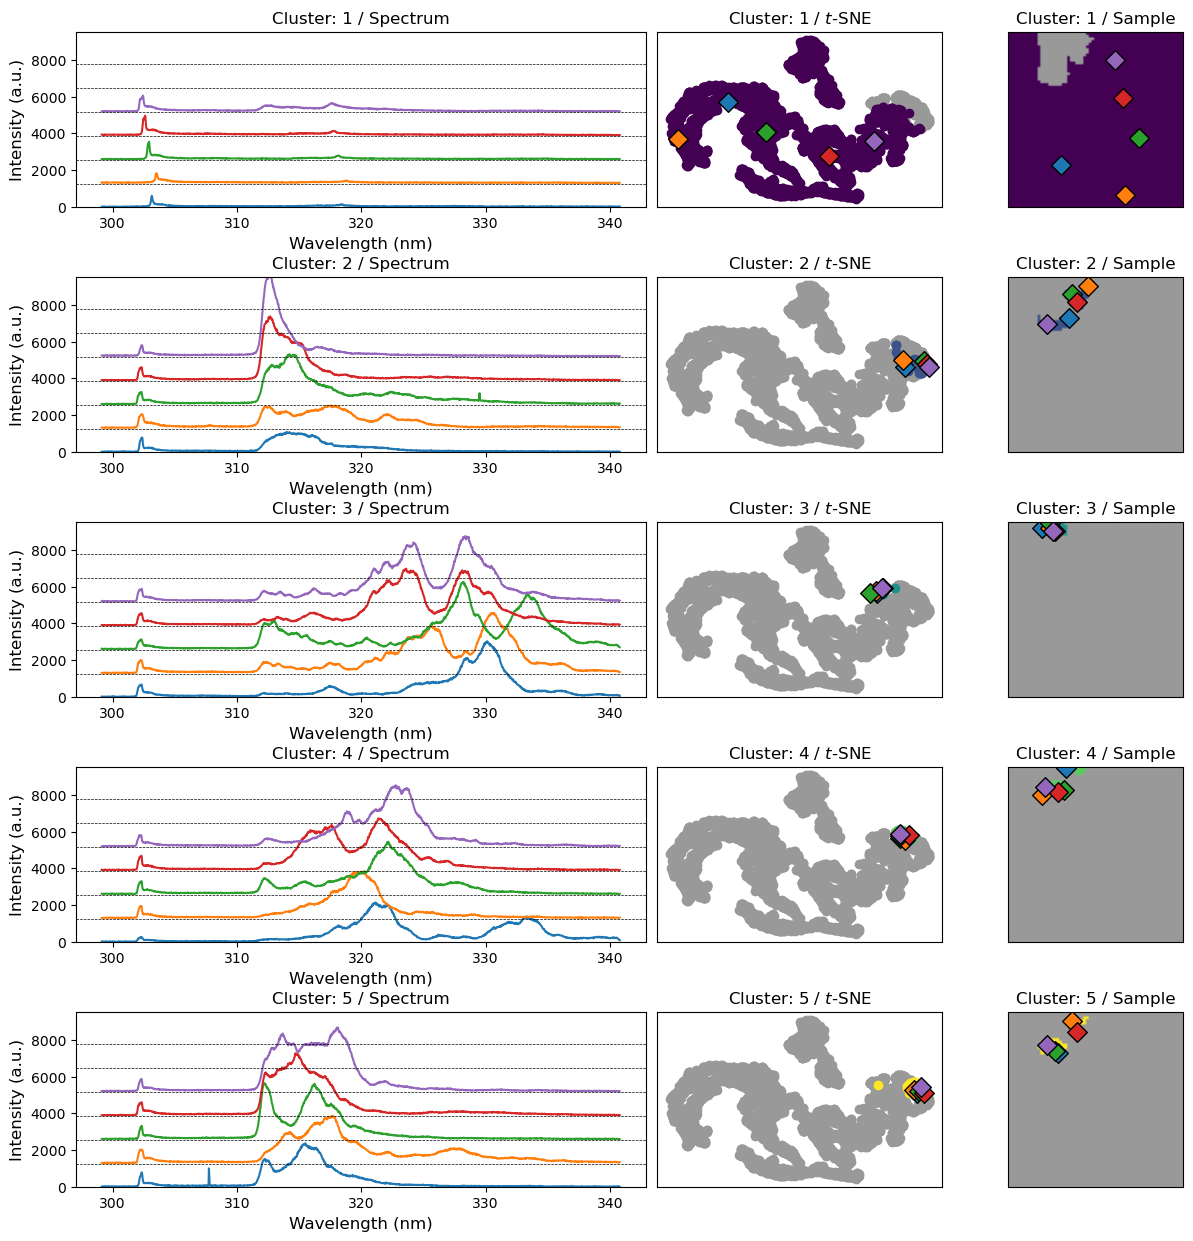

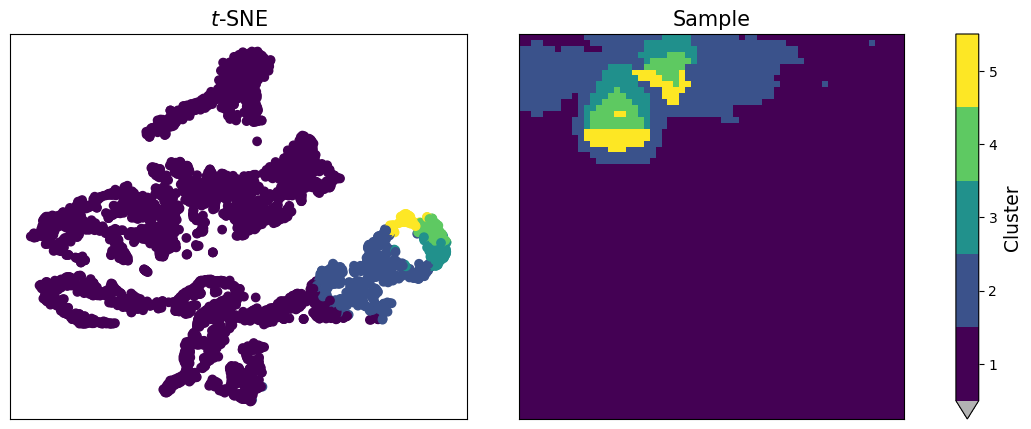

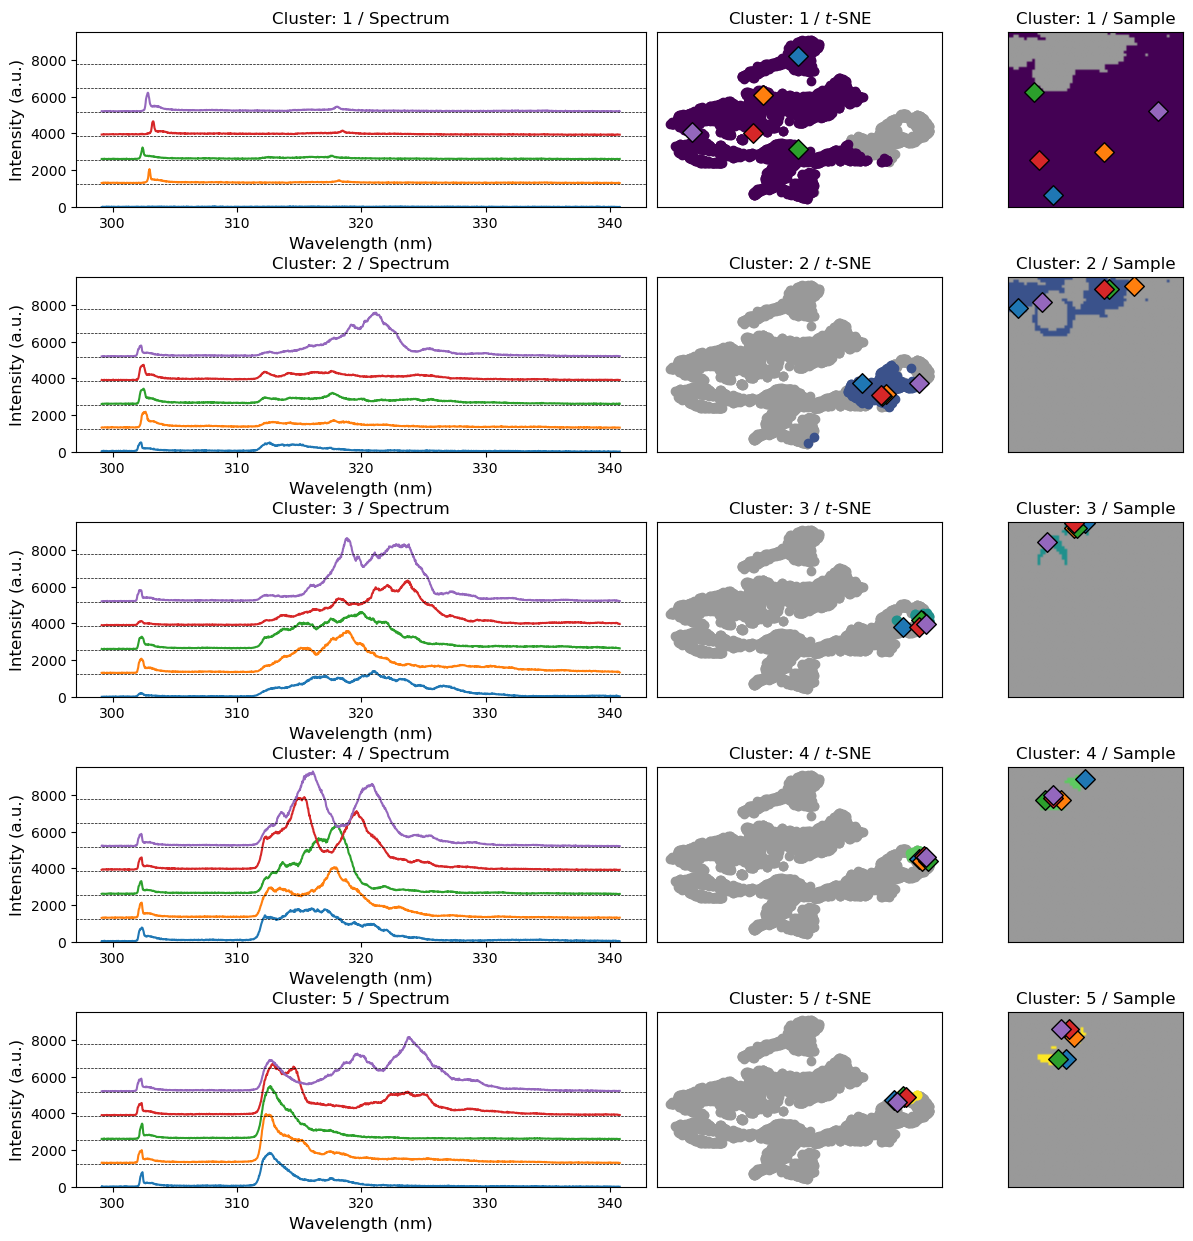

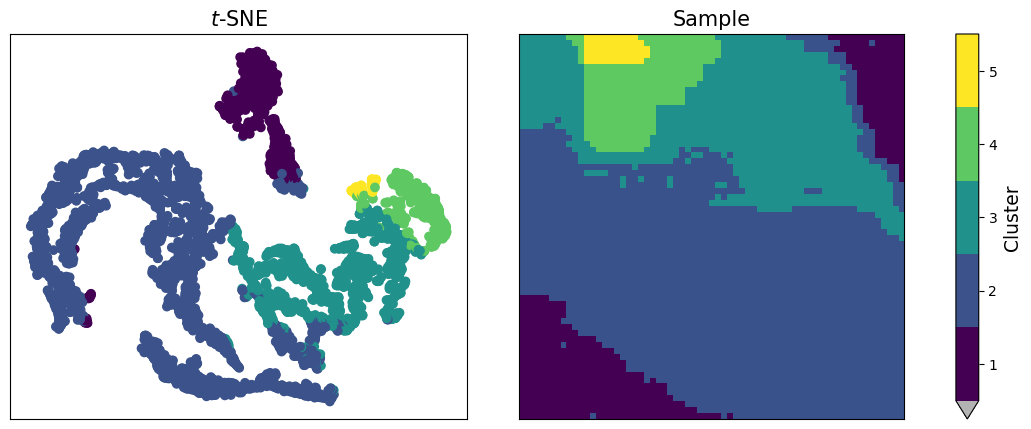

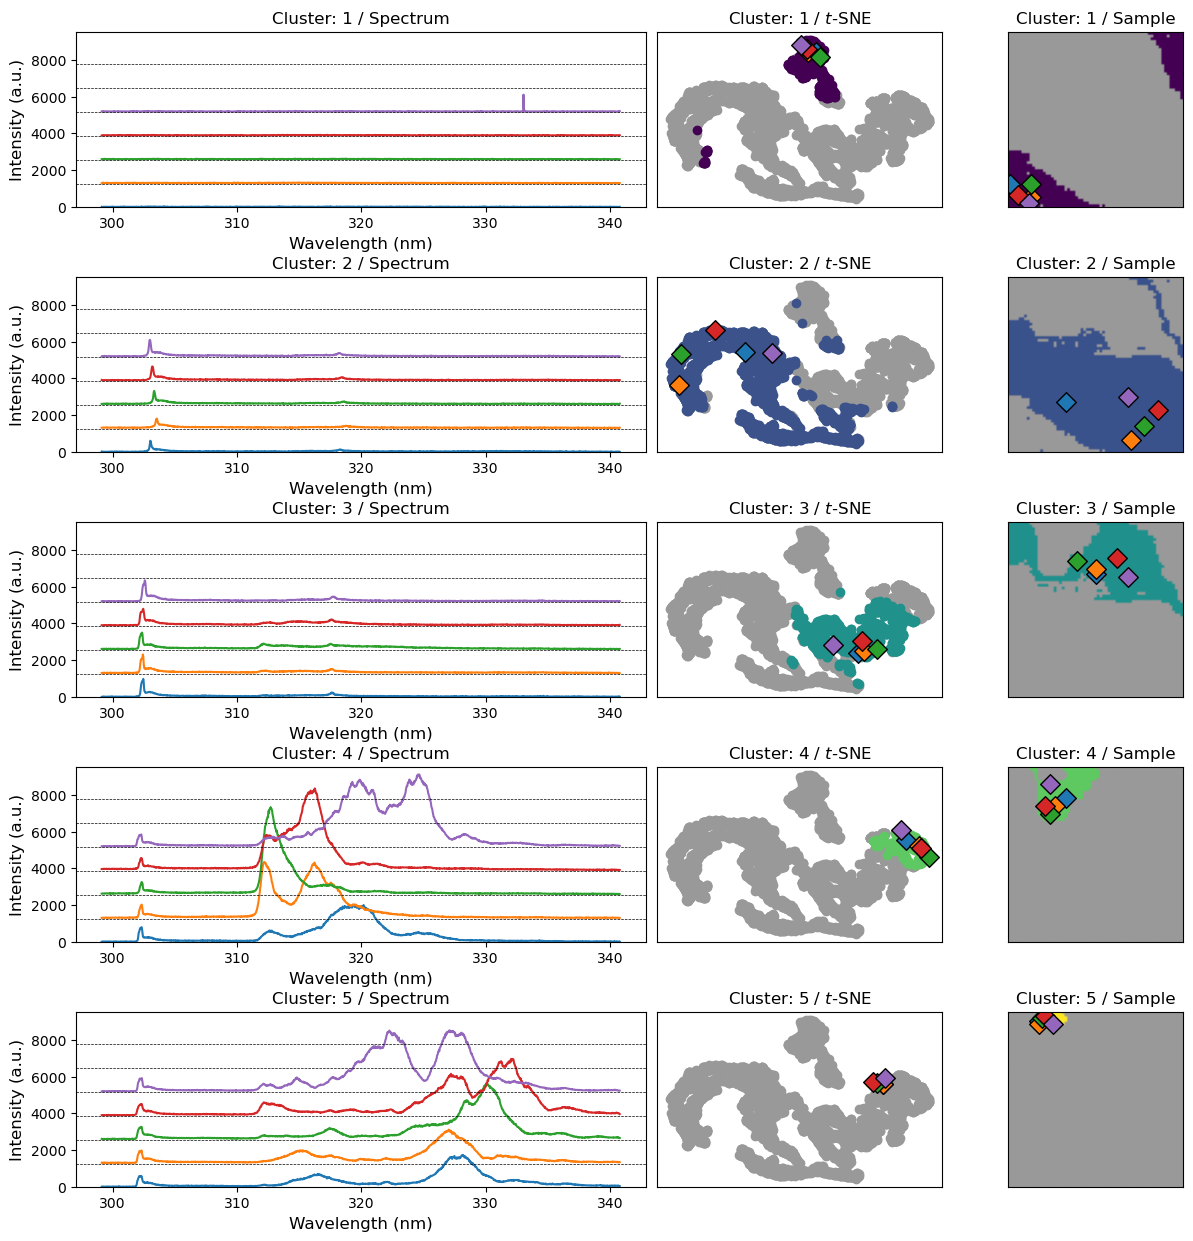

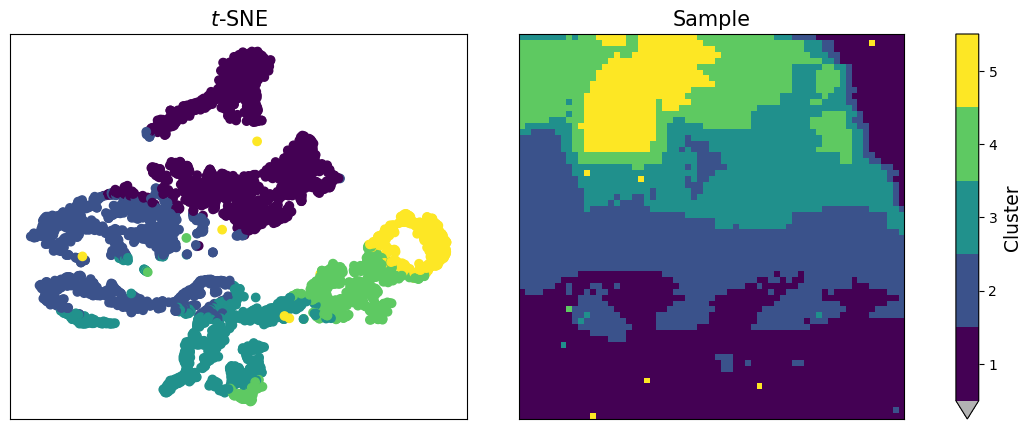

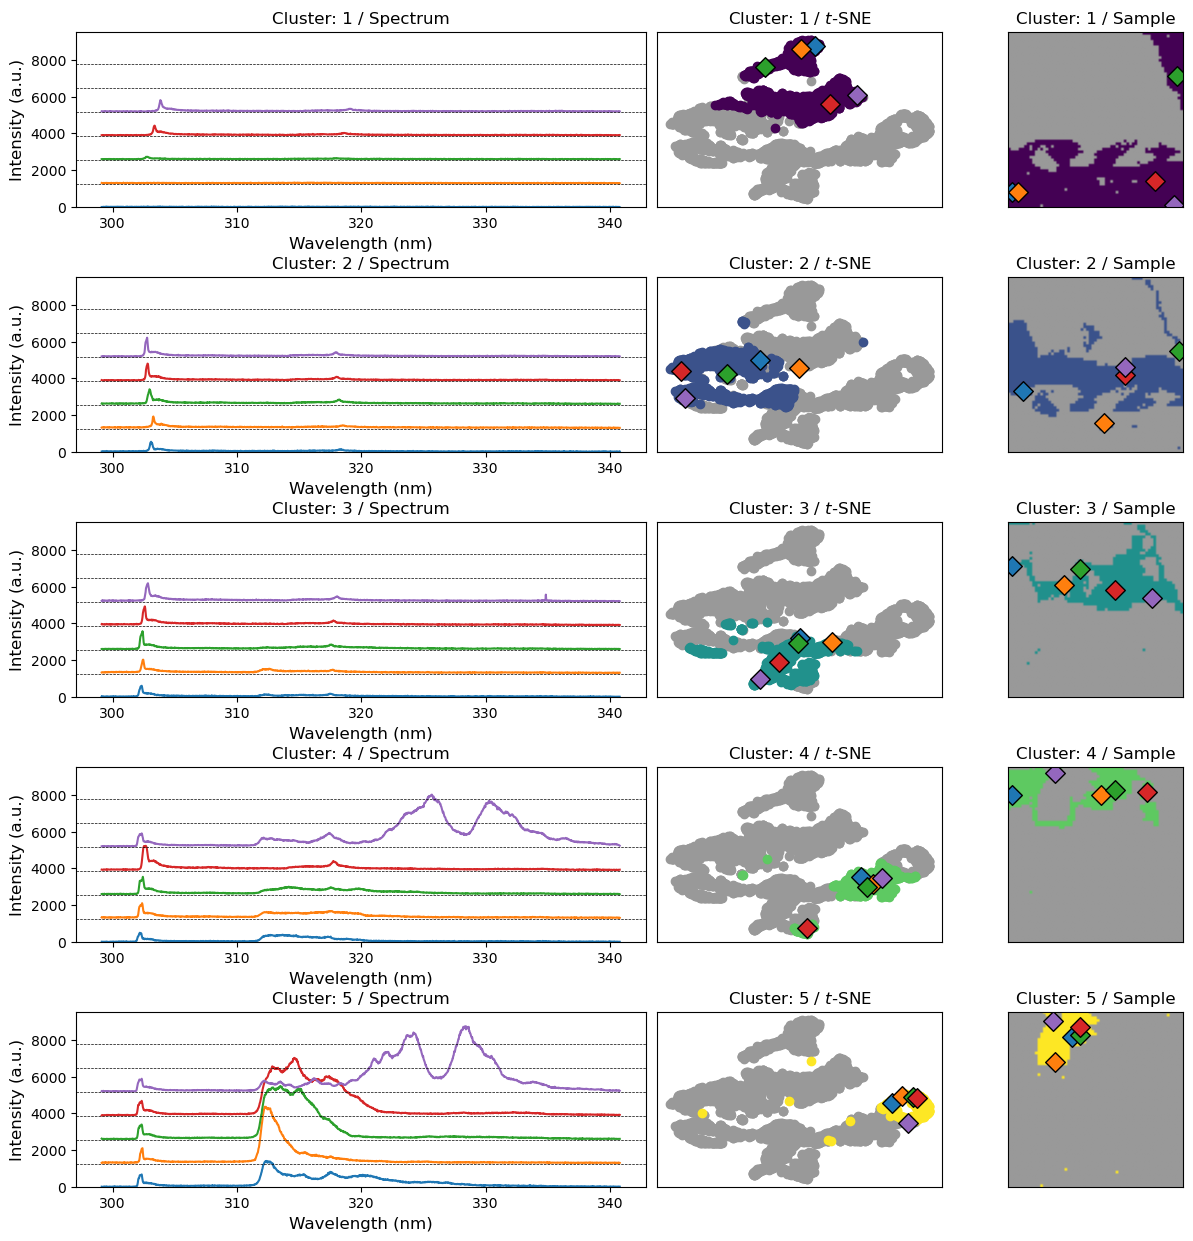

In [29]:
root = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/'
ns = np.array(sorted([f.split('.')[0] for f in os.listdir(root) if f.startswith('9') and f.endswith('txt')])).astype(int)

n = 902
x, y = read_spectrum(n, root)
m3, m4= plot_cluster(x, y)
m3, m4= plot_cluster(x, y, norm_std=4)
print('g')
m3, m4= plot_cluster(x, y, method='g')
m3, m4= plot_cluster(x, y, method='g', norm_std=4)

In [29]:
wave_unit_converters['eV']['nm'](np.array([4.1, 3.9, 3.7]))

array([302.40048398, 317.90820111, 335.0924282 ])

In [5]:
dat = {n:read_spectrum(n, root) for n in fns}

In [6]:
xs = {}
for n, (x, y) in dat.items():
    nx = x.shape[0]
    v = y.reshape(nx, -1).var(1)
    m = v != 0
    if np.sum(m) == 0:
        continue
    nmin, nmax = x[m].min(), x[m].max()
    xs[n] = {
        'n':n, 'len':np.sum(m), 'nm': (nmin, nmax), 'ev':wave_unit_converters['nm']['eV'](np.array([nmin, nmax]))
    }

[]

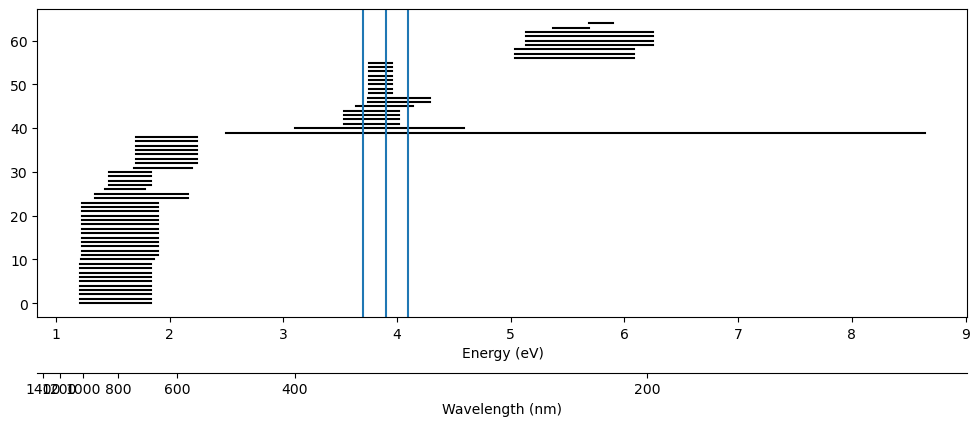

In [18]:
xs_ev = np.array([v['ev'] for v in xs.values()])
l = np.array([v['len'] for v in xs.values()])
c = (l) / (l.max())
cs = mpl.cm.viridis(c)
f, ax = plt.subplots(1,1,figsize=(12,4))
for i, [x0, x1] in zip(np.argsort(np.argsort(xs_ev.T[1])), xs_ev):
    ax.plot([x0, x1], [i,i], c='k')
ax.axvline(4.1)
ax.axvline(3.9)
ax.axvline(3.7)
ax.set_xlabel('Energy (eV)')

from utils.visualize import add_axes_units

axs = add_axes_units(ax, base='eV', units=['nm'], padding=40)
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_yticks([])

In [71]:
l

array([1340, 1340, 1340, 1340, 1328,   30,  494,   49, 1340, 1340, 1340,
       1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340,
       1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340,
       1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340,  134,  134,
        134,  134,  134,  134,  134,  134, 1340, 1340, 1340, 1340, 1340,
       1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340])

In [51]:
maxs, mins = xs_ev.T
fns[(mins < 3.9) & (maxs > 4.1)]

array([902, 904, 906, 960, 964])

(<_io.BytesIO at 0x7fea01c51900>, <_io.BytesIO at 0x7fea00e6cae0>)

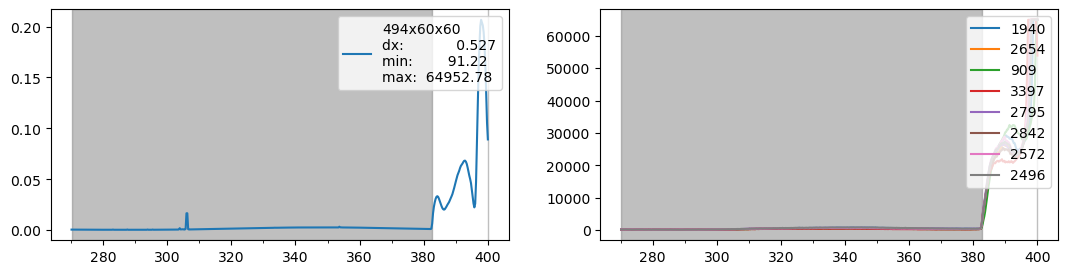

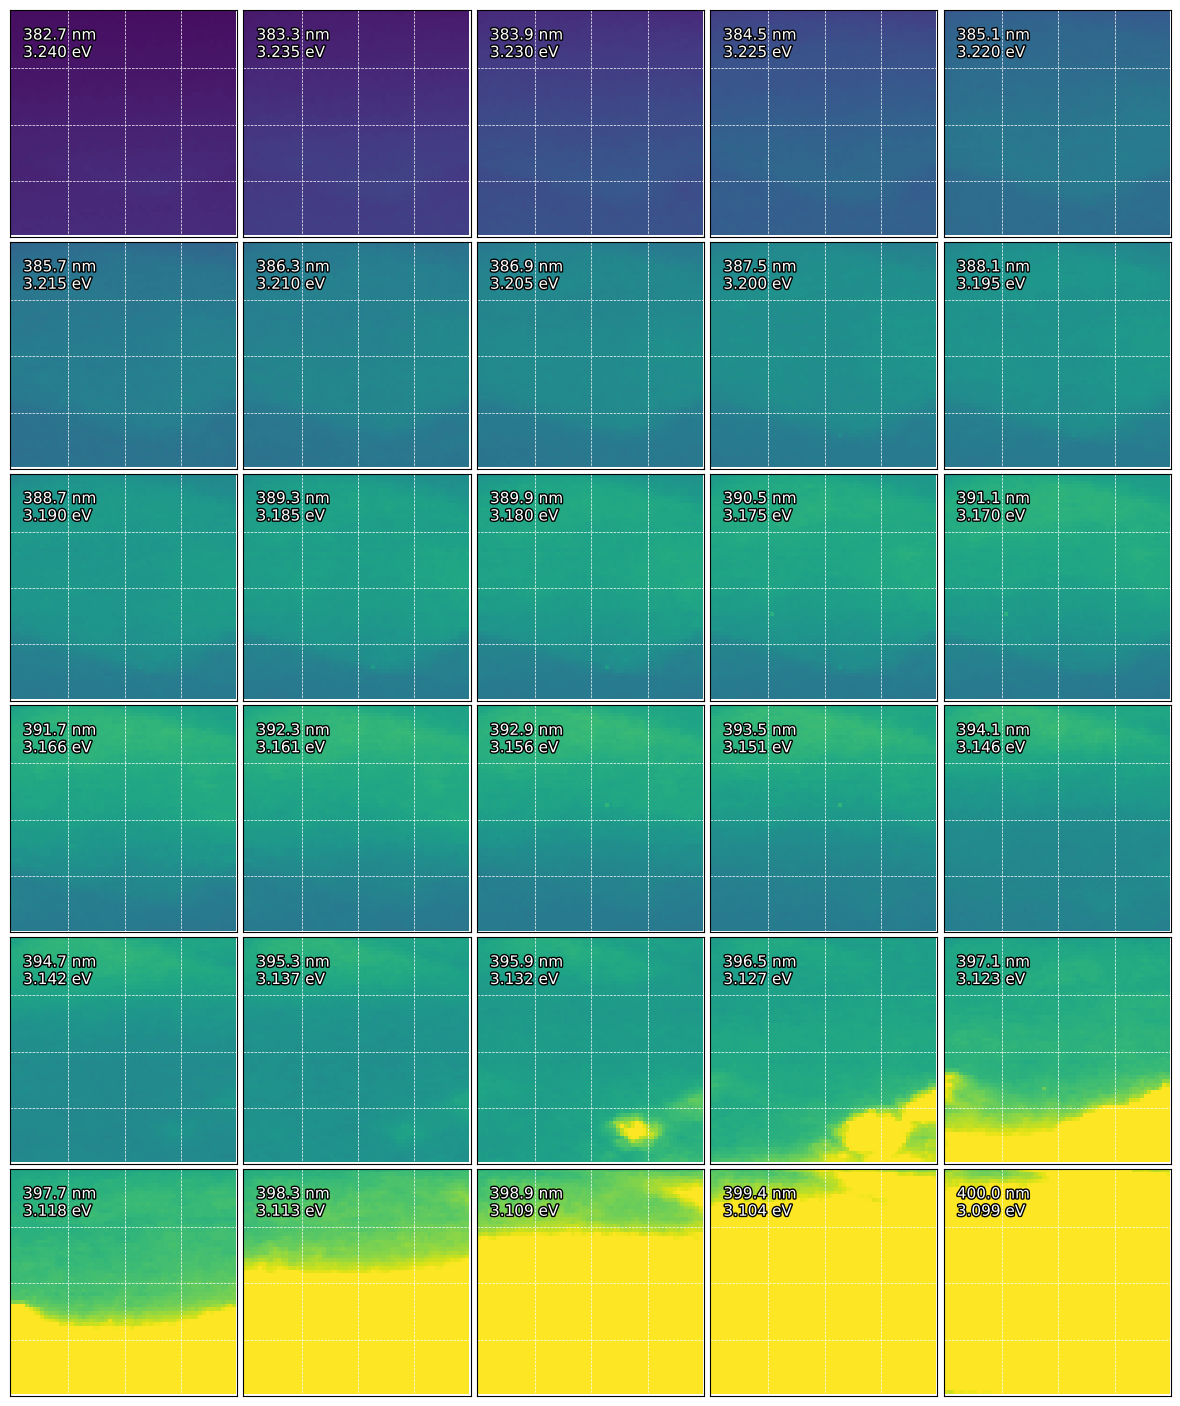

In [53]:
x, y = read_spectrum(906, root)
plot_info_and_maps(x, y)

# Autoencoder

In [65]:
from utils.spectrumdata import SpectrumAEDataset, collate_fn
from utils.trainer import SAETrainer
from srs.snet import SpectrumAutoEncoder
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

input_file = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/902.txt'
x, ys = read_spectrum('902', root='/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum')
nx, n1, n2 = ys.shape


ds = SpectrumAEDataset(length=1024)
ds.from_data(x, ys)
dl = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = SpectrumAutoEncoder(1, 8, 4, 1024, 2, 4, 32, 16)
model.to('cuda')
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
step = StepLR(opt, step_size=50, gamma=0.7)
record = []
trainer = SAETrainer(model, opt)
m = 1e5
for i in range(3000):
    loss = trainer.train(dl)
    record.append([i, loss])
    step.step()
    if loss < m:
        m = loss
        i_best = i
        best = trainer.pred(dl)
    if i < 100:
        print(i, loss, end='\r')
    else:
        print(i, loss, '\t', i_best, m, end='\r')


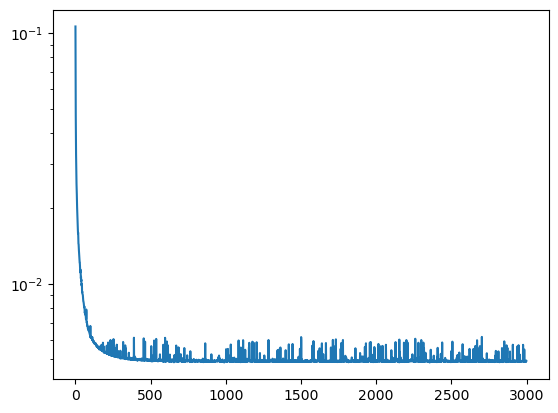

In [26]:
xs = ds.xs
inp = best['None_None']['tgt']
prd = best['None_None']['pred']
latent = best['None_None']['latent']
epoch, loss = np.array(record).T
plt.plot(epoch, loss)
plt.yscale('log')

In [27]:
ds.infos

array([['None', 'None', '-35.0285', '4333.076499999999', '0'],
       ['None', 'None', '-35.0285', '4333.076499999999', '1'],
       ['None', 'None', '-35.0285', '4333.076499999999', '2'],
       ...,
       ['None', 'None', '-35.0285', '4333.076499999999', '4222'],
       ['None', 'None', '-35.0285', '4333.076499999999', '4223'],
       ['None', 'None', '-35.0285', '4333.076499999999', '4224']],
      dtype='<U32')

[2650  710 2761 3952  419 1977 2774 2455 1506 3252  758 2108  956 2353
 1627 1117]


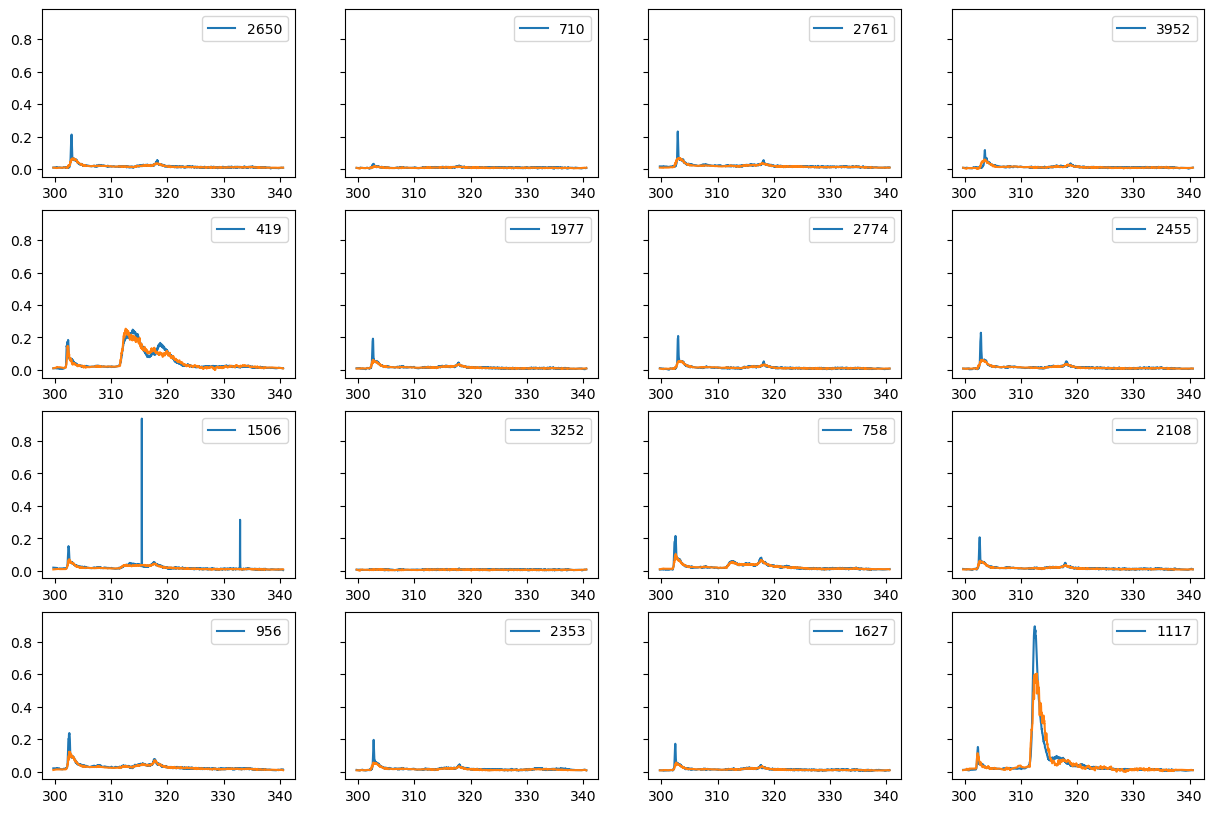

In [30]:
idxs = np.random.randint(0,4225, 16)
print(idxs)
f, axs = plt.subplots(4,4,figsize=(15,10), sharey=True)
for i, ax in zip(idxs, axs.reshape(-1)):
    ax.plot(xs, inp[i], label=str(i))
    ax.plot(xs, prd[i])
    ax.legend(loc='upper right')

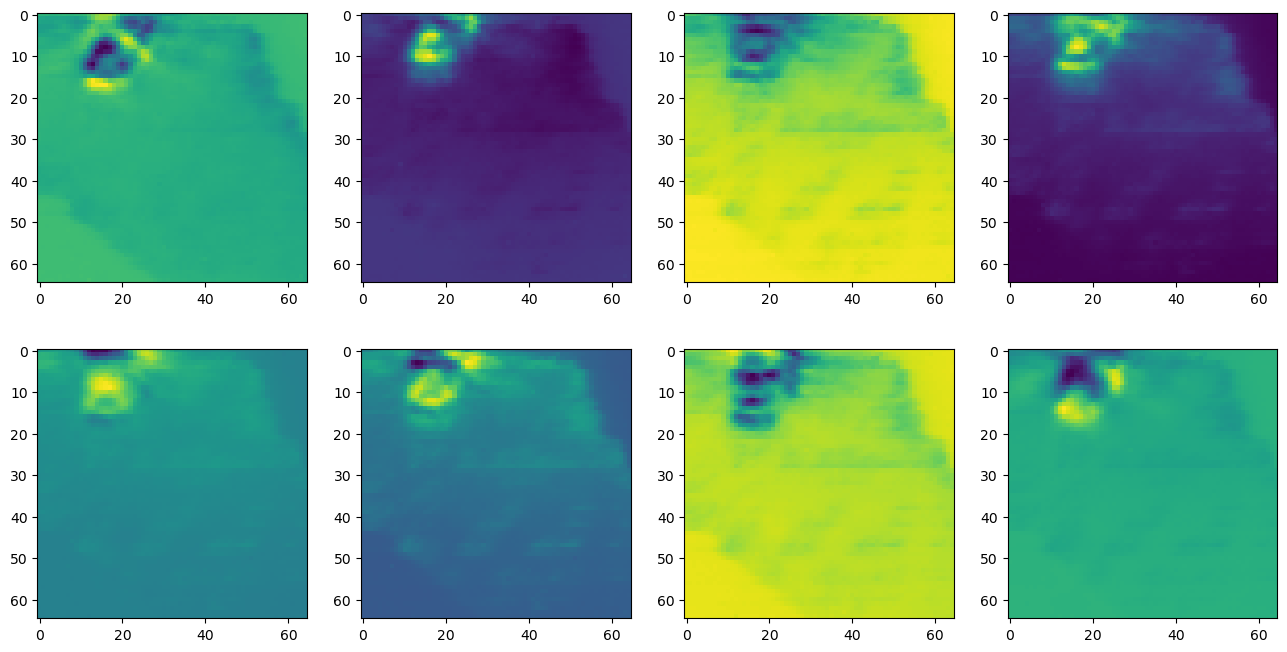

In [33]:
nx, n1, n2 = ys.shape
f, axs = plt.subplots(2,4,figsize=(16,8))
for ax, l in zip(axs.reshape(-1), latent.T):
    ax.imshow(l.reshape(n1,n2))

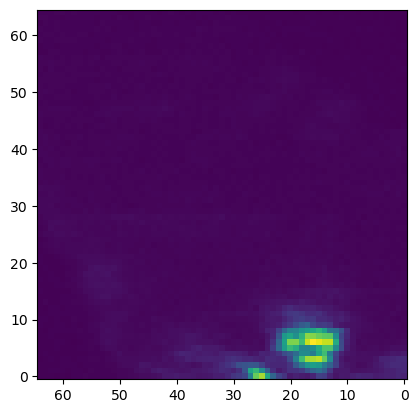

In [26]:
f, ax = plt.subplots(1,1)
ax.imshow(y[800])
ax.invert_xaxis()
ax.invert_yaxis()

/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jhyang/anaconda3/envs/image/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


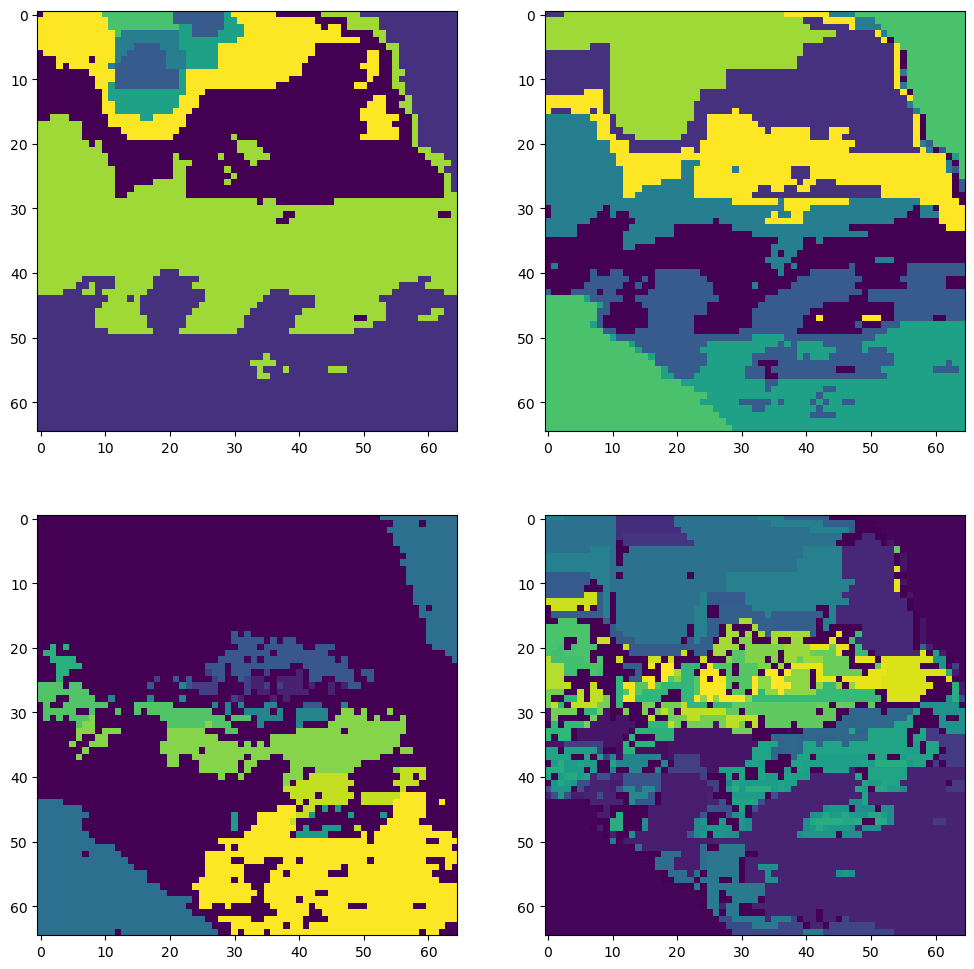

In [61]:
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
tsne = TSNE(perplexity=20, random_state=100)
tvec = tsne.fit_transform(latent)
km = KMeans(8)
k_l = km.fit_predict(latent)
k_t = km.fit_predict(tvec)

hdb = HDBSCAN(10)
h_l = hdb.fit_predict(latent)
h_t = hdb.fit_predict(tvec)

f, axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].imshow(k_l.reshape(n1,n2))
axs[0,1].imshow(k_t.reshape(n1,n2))
axs[1,0].imshow(h_l.reshape(n1,n2))
axs[1,1].imshow(h_t.reshape(n1,n2))

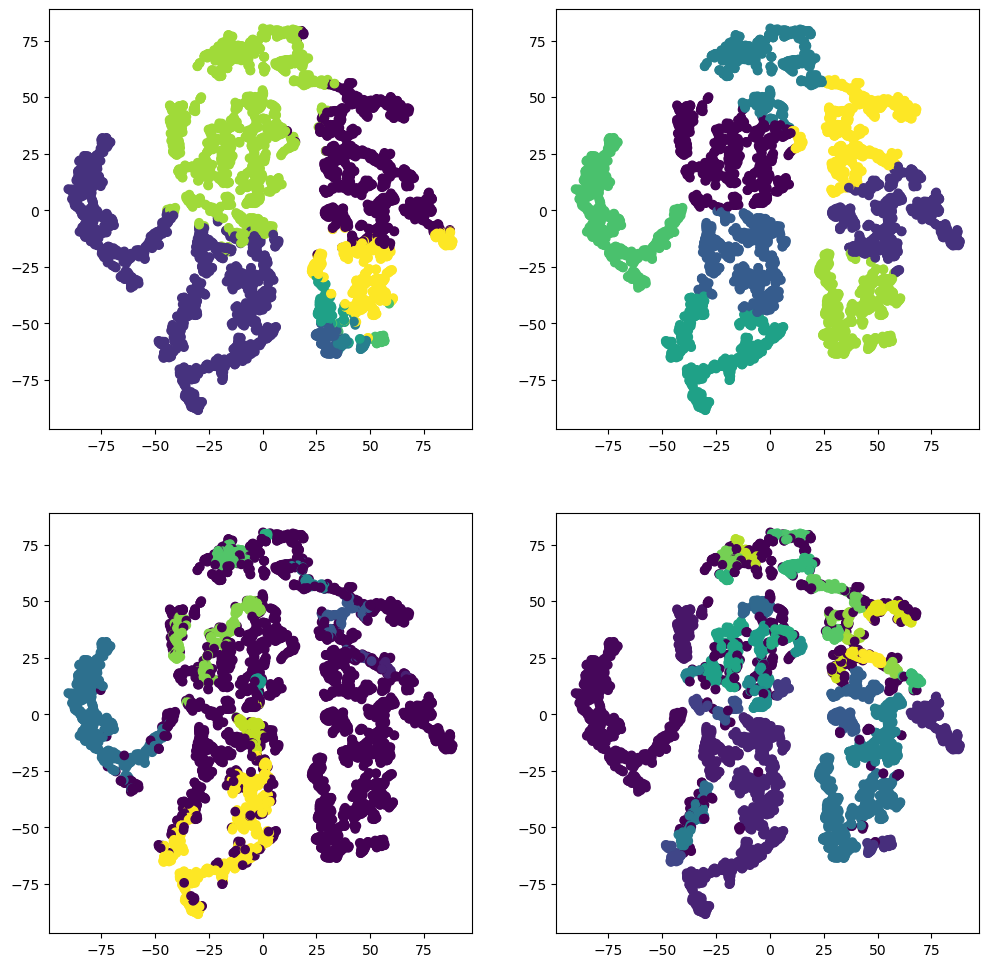

In [62]:
f, axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].scatter(*tvec.T, c=k_l)
axs[0,1].scatter(*tvec.T, c=k_t)
axs[1,0].scatter(*tvec.T, c=h_l)
axs[1,1].scatter(*tvec.T, c=h_t)